In [1]:
# Import Library
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from keras.preprocessing.image import ImageDataGenerator #, img_to_array, 
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import os

import warnings
warnings.filterwarnings("ignore")

# Prepare and Review Dataset

In [2]:
# Test and Train path
train_path = "seg_train\seg_train"
test_path = "seg_test\seg_test"

In [3]:
# The number of classes of dataset
numberOfClass = len(glob(train_path + "/*"))
print("Number Of Class: ", numberOfClass)

Number Of Class:  6


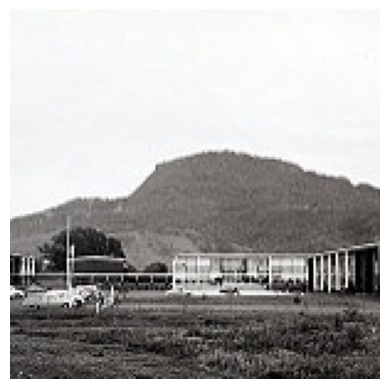

In [4]:
# Visualize
img = load_img(train_path + r'\buildings\0.jpg')
plt.imshow(img)
plt.axis("off")
plt.show()

In [5]:
# The images size in dataset.
image_shape = img_to_array(img)
print(image_shape.shape)

(150, 150, 3)


In [6]:
# Prepare the datasef for vgg16
train_data = ImageDataGenerator().flow_from_directory(train_path, target_size = (224,224))
test_data = ImageDataGenerator().flow_from_directory(test_path, target_size = (224,224))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Visualizzazione di un campione delle immagini

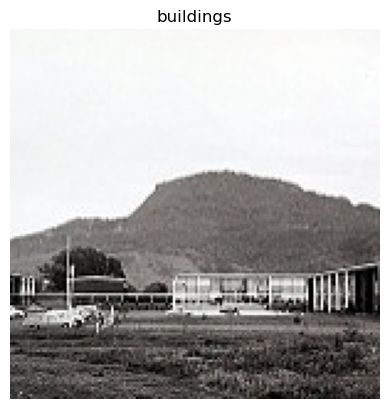

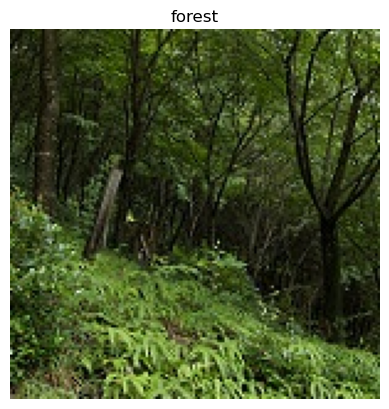

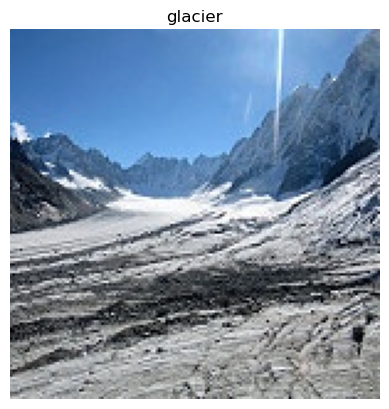

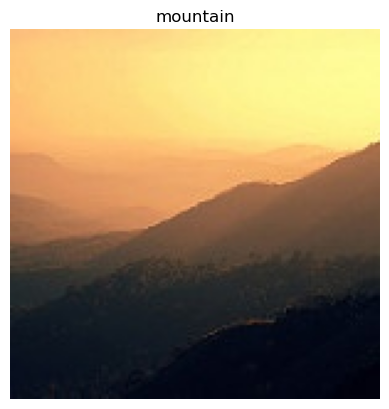

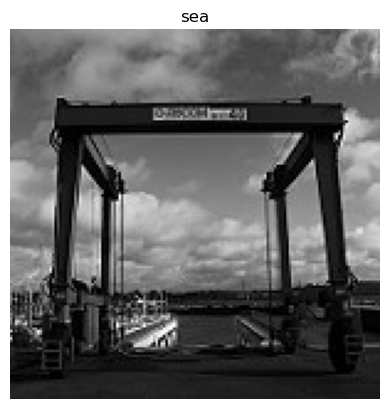

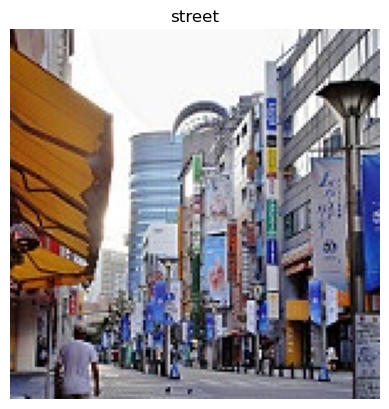

In [7]:
for i in os.listdir(train_path):
    for j in os.listdir(train_path+"/" + i):
        img = load_img(train_path+"/" + i + "/" + j)
        plt.imshow(img)
        plt.title(i)
        plt.axis("off")
        plt.show()
        break

# Creazione del modello di Vgg16

In [24]:
# Import model
vgg16 = VGG16()

553467096/553467096 [==============================] - 102s 0us/step


In [25]:
# Layers of vgg16 
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:
# layers of vgg16
vgg16_layer_list = vgg16.layers
for i in vgg16_layer_list:
    print(i)

In [27]:
# add the layers of vgg16 in my created model.
vgg16Model = Sequential()
for i in range(len(vgg16_layer_list)-1):
    vgg16Model.add(vgg16_layer_list[i])

In [28]:
# Close the layers of vgg16
for layers in vgg16Model.layers:
    layers.trainable = False

In [29]:
# Last layer
vgg16Model.add(Dense(numberOfClass, activation = "softmax"))

In [30]:
# After I added last layer in created model.
vgg16Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [31]:
# I create compile part.
vgg16Model.compile(loss = "categorical_crossentropy",
             optimizer = "rmsprop",
             metrics = ["accuracy"])

# Training Model 

In [33]:
# Traning with model
batch_size = 32

hist_vgg16 = vgg16Model.fit_generator(train_data, 
                                      steps_per_epoch = 1600 // batch_size, 
                                      epochs = 10, 
                                      validation_data = test_data, 
                                      validation_steps = 800 // batch_size)

Epoch 1/10
50/50 [==============================] - 276s 6s/step - loss: 0.7055 - accuracy: 0.7650 - val_loss: 0.5837 - val_accuracy: 0.7750
Epoch 2/10
50/50 [==============================] - 264s 5s/step - loss: 0.5137 - accuracy: 0.8281 - val_loss: 0.3790 - val_accuracy: 0.8575
Epoch 3/10
50/50 [==============================] - 469s 9s/step - loss: 0.3976 - accuracy: 0.8637 - val_loss: 0.3792 - val_accuracy: 0.8750
Epoch 4/10
50/50 [==============================] - 269s 5s/step - loss: 0.4307 - accuracy: 0.8662 - val_loss: 0.3854 - val_accuracy: 0.8725
Epoch 5/10
50/50 [==============================] - 340s 7s/step - loss: 0.3864 - accuracy: 0.8800 - val_loss: 0.4280 - val_accuracy: 0.8637
Epoch 6/10
50/50 [==============================] - 261s 5s/step - loss: 0.3717 - accuracy: 0.8838 - val_loss: 0.3941 - val_accuracy: 0.8725
Epoch 7/10
50/50 [==============================] - 236s 5s/step - loss: 0.4006 - accuracy: 0.8650 - val_loss: 0.3992 - val_accuracy: 0.8800
Epoch 8/10
50

In [34]:
# Save the weights of model
vgg16Model.save_weights("deneme.h5")

# Andiamo a visualizzare i risultati della rete

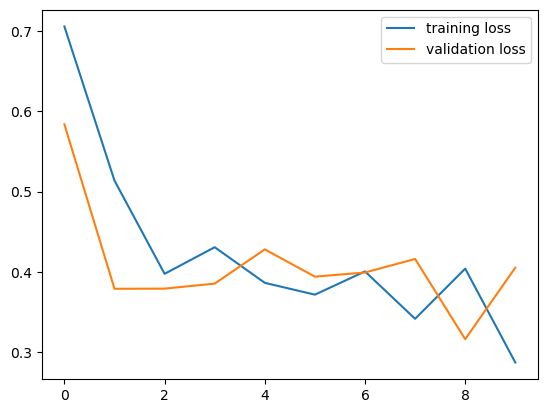

In [35]:
# Loss and Validation Loss
plt.plot(hist_vgg16.history["loss"], label = "training loss")
plt.plot(hist_vgg16.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

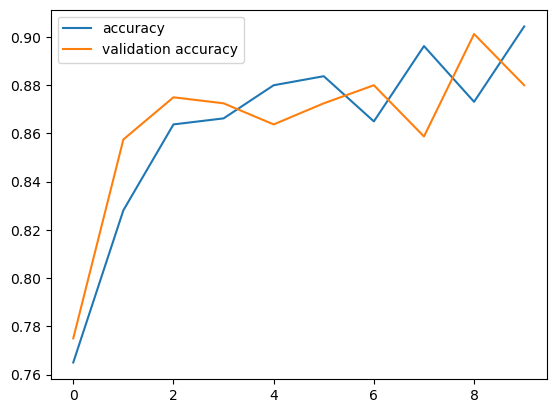

In [36]:
# Accuracy and Validation Accuracy
plt.plot(hist_vgg16.history["accuracy"], label = "accuracy")
plt.plot(hist_vgg16.history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.show()

# Salviamo e carichiamo i risultati

In [37]:
import json, codecs
with open("deneme.json","w") as f:
    json.dump(hist_vgg16.history, f)

In [38]:
with codecs.open("./deneme.json","r", encoding = "utf-8") as f:
    load_result = json.loads(f.read())

In [39]:
load_result

{'loss': [0.7054945230484009,
  0.5136629343032837,
  0.3976057469844818,
  0.4307115972042084,
  0.3863684833049774,
  0.3716677725315094,
  0.40057018399238586,
  0.3416111469268799,
  0.40405699610710144,
  0.28724029660224915],
 'accuracy': [0.7649999856948853,
  0.828125,
  0.8637499809265137,
  0.8662499785423279,
  0.8799999952316284,
  0.8837500214576721,
  0.8650000095367432,
  0.8962500095367432,
  0.8731250166893005,
  0.9043750166893005],
 'val_loss': [0.5836769342422485,
  0.3789961338043213,
  0.37915927171707153,
  0.38540345430374146,
  0.42800384759902954,
  0.3940734565258026,
  0.39924734830856323,
  0.41608214378356934,
  0.3162184953689575,
  0.40526703000068665],
 'val_accuracy': [0.7749999761581421,
  0.8575000166893005,
  0.875,
  0.8725000023841858,
  0.8637499809265137,
  0.8725000023841858,
  0.8799999952316284,
  0.8587499856948853,
  0.9012500047683716,
  0.8799999952316284]}

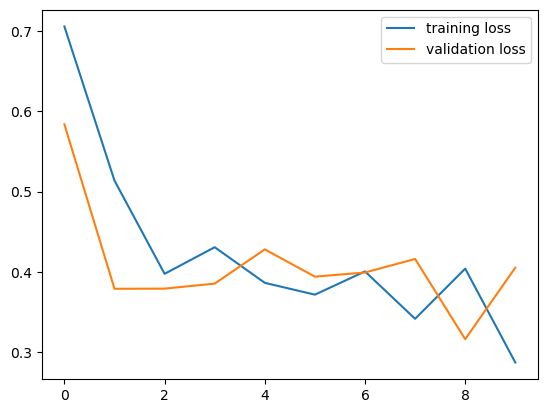

In [40]:
# Loss And Validation Loss
plt.plot(load_result["loss"], label = "training loss")
plt.plot(load_result["val_loss"], label = "validation loss")
plt.legend()
plt.show()

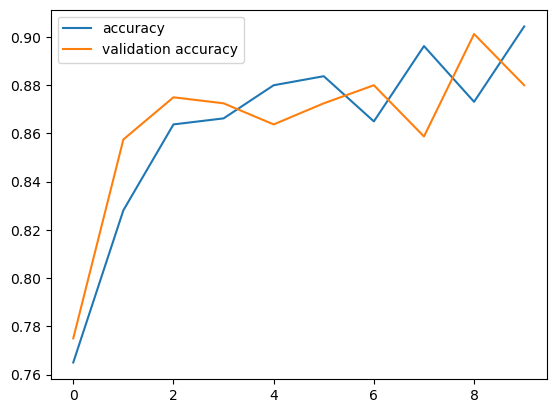

In [41]:
plt.plot(load_result["accuracy"], label = "accuracy")
plt.plot(load_result["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.show()

# Vgg19

In [8]:
# Import VGG19 model
vgg19 = VGG19()

574710816/574710816 [==============================] - 114s 0us/step


In [9]:
# Layers of vgg19
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
# Layers of vgg19 
vgg19_layer_list = vgg19.layers
for i in vgg19_layer_list:
    print(i)

In [11]:
# add the layers of vgg16 in my created model.
vgg19Model = Sequential()
for i in range(len(vgg19_layer_list)-1):
    vgg19Model.add(vgg19_layer_list[i])

In [12]:
# Finish version of my created model.
vgg19Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [13]:
# Close the layers of vgg16
for layers in vgg19Model.layers:
    layers.trainable = False

In [14]:
# Last layer
vgg19Model.add(Dense(numberOfClass, activation = "softmax"))

In [15]:
# the final version of the model
vgg19Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [16]:
# I create compile part.
vgg19Model.compile(loss = "categorical_crossentropy",
             optimizer = "rmsprop",
             metrics = ["accuracy"])

# Addestramento

In [19]:
# Traning with model
batch_size = 32

# Training with my created model
hisy_vgg19 = vgg19Model.fit_generator(train_data,
                               steps_per_epoch = 1600 // batch_size,
                               epochs = 10,
                               validation_data = test_data,
                               validation_steps = 800 // batch_size)

Epoch 1/10
50/50 [==============================] - 700s 14s/step - loss: 0.6683 - accuracy: 0.7713 - val_loss: 0.4304 - val_accuracy: 0.8600
Epoch 2/10
50/50 [==============================] - 622s 12s/step - loss: 0.4122 - accuracy: 0.8581 - val_loss: 0.4579 - val_accuracy: 0.8550
Epoch 3/10
50/50 [==============================] - 313s 6s/step - loss: 0.4227 - accuracy: 0.8588 - val_loss: 0.4613 - val_accuracy: 0.8462
Epoch 4/10
50/50 [==============================] - 317s 6s/step - loss: 0.3969 - accuracy: 0.8744 - val_loss: 0.4060 - val_accuracy: 0.8687
Epoch 5/10
50/50 [==============================] - 395s 8s/step - loss: 0.3667 - accuracy: 0.8856 - val_loss: 0.5224 - val_accuracy: 0.8388
Epoch 6/10
50/50 [==============================] - 319s 6s/step - loss: 0.3512 - accuracy: 0.8794 - val_loss: 0.4440 - val_accuracy: 0.8625
Epoch 7/10
50/50 [==============================] - 318s 6s/step - loss: 0.3539 - accuracy: 0.8850 - val_loss: 0.4862 - val_accuracy: 0.8575
Epoch 8/10


# Visualizziamo i risultati ottenuti

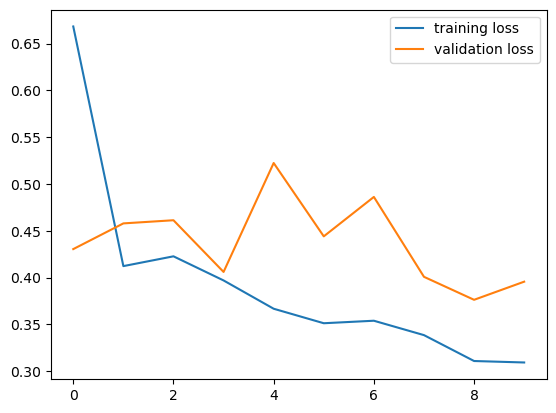

In [20]:
# Loss And Validation Loss
plt.plot(hisy_vgg19.history["loss"], label = "training loss")
plt.plot(hisy_vgg19.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

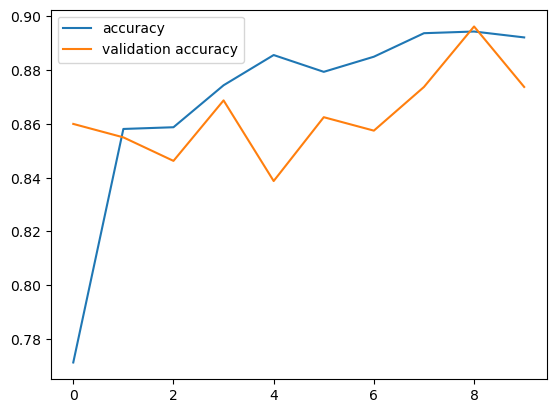

In [21]:
# Accuracy And Validation Accuracy
plt.plot(hisy_vgg19.history["accuracy"], label = "accuracy")
plt.plot(hisy_vgg19.history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.show()